# Convolutional Neural Network IMBD

Proyecto para Interpretación de sentimientos con Lenguaje Natural

## Librerias

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
#import numpy as np
#import tensorflow as tf
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from sklearn.feature_extraction.text import CountVectorizer

In [107]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import ngrams as nltk_ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('words')
english_words = set(words.words())
import re
import string

lemmatizer = WordNetLemmatizer()

from collections import Counter


## Limpieza y preparación de Datos

In [108]:
df = pd.read_csv("./Data/IMDB Dataset.csv")
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [109]:
#Convertir sentimiento a bolean
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [110]:
df['review'][0:3]

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
Name: review, dtype: object

In [111]:
#Proceso de limpieza de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()

    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)

    # Eliminar nombres propios
    text = re.sub(r'\b[A-Z][a-z]+(?:\'[a-z]+)?\b', '', text)

    # Eliminar frases entre comillas dobles
    text = re.sub(r'\".*?\"', '', text)

    # Eliminar contenido entre corchetes
    text = re.sub(r'\[.*?\]', '', text)

    # Eliminar puntuación
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Eliminar palabras con números
    text = re.sub(r'\w*\d\w*', '', text)

    # Eliminar caracteres repetidos
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Eliminar números
    text = re.sub(r'\d+', '', text)

    # Eliminar palabras muy largas o muy cortas
    text = ' '.join([word for word in text.split() if 2 <= len(word) <= 16])

    # Eliminar stopwords, conservando palabras específicas
    stop_words = set(stopwords.words('english'))
    keep_words = {'what', 'who', 'why', 'when', 'where', 'how'}  # Palabras importantes
    wordss = text.split()
    text = ' '.join([word for word in wordss if word not in stop_words or word in keep_words])

    # Filtrar palabras que contengan solo letras
    text = ' '.join([word for word in text.split() if word.isalpha()])

    # Filtrar palabras con prefijos anómalos
    text = ' '.join([word for word in text.split() if not word.startswith('aa')])
    # Lematización
    lemmatizerr = WordNetLemmatizer()
    text = ' '.join([lemmatizerr.lemmatize(word) for word in text.split()])

    return text


In [112]:
df_preprocessed = df.copy()

In [113]:
df_preprocessed['review'] = df_preprocessed['review'].apply(preprocess_text)

## EDA

### Longitud de reviews

### Distribución de Clases

### Promedio de Longitud por Clase

### Palabras más frecuentes

### Longitud de Vocabulario

### Correlación longitud y sentimiento

### Generar bigramas

Creamos bigramas para hacer relación más rapidamente de las combinaciónes que definen un comentario positivo y negativo

In [114]:
def generate_ngrams(text, n):
    tokens = text.lower().split()
    n_grams = list(nltk_ngrams(tokens, n))  # Use the imported function
    return n_grams

n = 2  # You can change this to generate different n-grams (e.g., 3 for trigrams)
df_preprocessed['ngrams'] = df_preprocessed['review'].apply(lambda x: generate_ngrams(x, n))

# Separate ngrams by sentiment
positive_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 1 for ngram in ngrams_list]
negative_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 0 for ngram in ngrams_list]

In [115]:
df_preprocessed.head()

,review,sentiment,ngrams
0,one reviewer mentioned watching oz episode you...,1,"[(one, reviewer), (reviewer, mentioned), (ment..."
1,wonderful little production filming technique ...,1,"[(wonderful, little), (little, production), (p..."
2,thought wonderful way spend time hot summer we...,1,"[(thought, wonderful), (wonderful, way), (way,..."
3,basically there family where little boy jake t...,0,"[(basically, there), (there, family), (family,..."
4,petter matteis visually stunning film watch mr...,1,"[(petter, matteis), (matteis, visually), (visu..."


### Análisis de bigramas

In [116]:
positive_ngram_counts = Counter(positive_ngrams)
negative_ngram_counts = Counter(negative_ngrams)

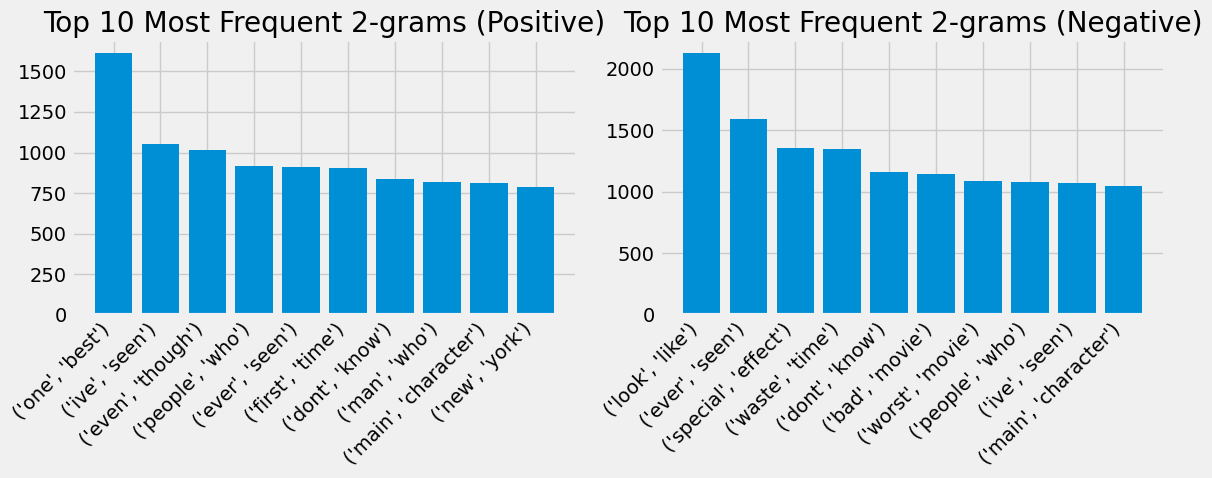

In [117]:
# graficar los mejores 10 ngramas por categoria
top_n = 10

top_positive_ngrams = positive_ngram_counts.most_common(top_n)
top_negative_ngrams = negative_ngram_counts.most_common(top_n)

#Prepare data for plotting
ngrams_pos = [str(ngram) for ngram, count in top_positive_ngrams]
counts_pos = [count for ngram, count in top_positive_ngrams]

ngrams_neg = [str(ngram) for ngram, count in top_negative_ngrams]
counts_neg = [count for ngram, count in top_negative_ngrams]



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(ngrams_pos, counts_pos)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Positive)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(ngrams_neg, counts_neg)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Negative)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [118]:
df_preprocessed.head()

,review,sentiment,ngrams
0,one reviewer mentioned watching oz episode you...,1,"[(one, reviewer), (reviewer, mentioned), (ment..."
1,wonderful little production filming technique ...,1,"[(wonderful, little), (little, production), (p..."
2,thought wonderful way spend time hot summer we...,1,"[(thought, wonderful), (wonderful, way), (way,..."
3,basically there family where little boy jake t...,0,"[(basically, there), (there, family), (family,..."
4,petter matteis visually stunning film watch mr...,1,"[(petter, matteis), (matteis, visually), (visu..."


In [119]:
df_preprocessed = df_preprocessed.drop(columns=['ngrams'])

### Análisis por categorias

In [120]:
positive_reviews = df_preprocessed[df_preprocessed['sentiment'] == 1]['review']
negative_reviews = df_preprocessed[df_preprocessed['sentiment'] == 0]['review']

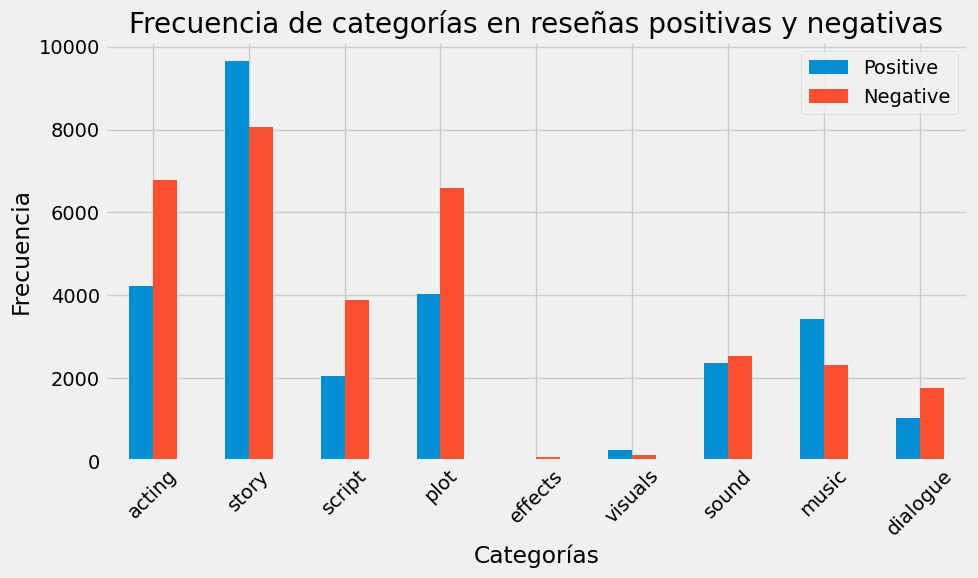

In [121]:
# Categorías clave a analizar
categories = ['acting', 'story', 'script', 'plot', 'effects', 'visuals', 'sound', 'music', 'dialogue']

# Función para buscar frecuencia de las categorías
def category_analysis(reviews, categories):
    frequencies = {}
    #examples = {}
    for category in categories:
        frequencies[category] = reviews.str.contains(category, case=False, na=False).sum()
    return frequencies

# reseñas positivas
positive_freq = category_analysis(positive_reviews, categories)

# reseñas negativas
negative_freq = category_analysis(negative_reviews, categories)

# Crear un DataFrame para frecuencias
freq_df = pd.DataFrame({'Positive': positive_freq, 'Negative': negative_freq})

# Gráfico de frecuencias
freq_df.plot(kind='bar', figsize=(10, 6))
plt.title('Frecuencia de categorías en reseñas positivas y negativas')
plt.ylabel('Frecuencia')
plt.xlabel('Categorías')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preparación de datos tokenización

## Crear capa de Vectorizacion

In [122]:
import tensorflow as tf

In [123]:
from tensorflow.keras.layers import TextVectorization

In [124]:
from tensorflow.keras import Model,Input

In [125]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D,  Dense, Dropout,LSTM,Input,Bidirectional
#GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [126]:
max_tokens=30000
output_seq_len=500
embedding_dim=128
batch_size=128 #tamaño de lotes
lstm_units=32

vectorize_layer=TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)
vectorize_layer.adapt(df_preprocessed['review'].values)

In [127]:
X = vectorize_layer(df_preprocessed['review'].values)
y= df_preprocessed['sentiment'].values

In [128]:
X.shape , y.shape

(TensorShape([50000, 500]), (50000,))

Pipeline de datos para entrenamiento:
carga > cachea > mezcla > agrupa en batches > prepara en paralelo

In [129]:
data=tf.data.Dataset.from_tensor_slices((X,y))  #dataset de tensorflow 
data=data.cache()                               #guarda datos en memoria útil trabajo en muchas epocas
data=data.shuffle(buffer_size=10000)            #evitar aprender patrones en el orden
data=data.batch(batch_size)                     #crea lotes para el entrenamiento
data=data.prefetch(tf.data.AUTOTUNE)            #trabajo en paralelo
data_iterator=data.as_numpy_iterator()          #Convierte el Dataset en un iterador de NumPy.

In [130]:
#X_train=data.take(int(.8*len(data)))
#X_val=data.skip(int(.8*len(data))).take(int(.2*len(data)+1))
#print(f'Train size: {len(X_train)},\nValidation size: {len(X_val)},\nTotal size: {len(data)}')


In [131]:
train_size = int(0.8 * len(data))
val_size   = int(0.1 * len(data))
test_size  = int(0.1 * len(data))

X_train = data.take(train_size)
X_val   = data.skip(train_size).take(val_size)
X_test  = data.skip(train_size + val_size).take(test_size)


In [132]:
def build_model():
    inputs=Input(shape=(output_seq_len,))
    x=Embedding(max_tokens+1,embedding_dim)(inputs)
    x=Dropout(.2)(x)
    x=Bidirectional(
        LSTM(lstm_units,return_sequences=True,dropout=0.2)
    )(x)
    x=Bidirectional(
        LSTM(lstm_units,dropout=.2)
    )(x)
    x=Dense(1,activation='sigmoid')(x)

    model=Model(inputs=inputs,outputs=x)
    return model

model=build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 500, 128)       │     3,840,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 500, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,906,241 (14.90 MB)

 Trainable params: 3,906,241 (14.90 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [134]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=96,show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [135]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [136]:
history=model.fit(
    X_train,
    epochs=15,
    validation_data=X_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs',write_images=True,write_steps_per_second=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='ckpt.keras',verbose=1,save_best_only=True)
    ]
)

Epoch 1/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7349 - loss: 0.5201
Epoch 1: val_loss improved from None to 0.28450, saving model to ckpt.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.7962 - loss: 0.4429 - val_accuracy: 0.8936 - val_loss: 0.2845
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8879 - loss: 0.2789
Epoch 2: val_loss improved from 0.28450 to 0.23709, saving model to ckpt.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.8896 - loss: 0.2733 - val_accuracy: 0.9115 - val_loss: 0.2371
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9239 - loss: 0.2032
Epoch 3: val_loss improved from 0.23709 to 0.18796, saving model to ckpt.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.9217 - loss: 0.2057 - val_accuracy: 0.9299 - val_loss: 0.1880
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9450 - loss: 0.1542   
Epoch 4: val_loss improved from 0.18796 to 0.17504, saving model to c

In [140]:
df=pd.DataFrame(history.history)
df.to_csv('model_metrics.csv')

In [142]:
df

,Unnamed: 0,accuracy,loss,val_accuracy,val_loss
0,0,0.796174,0.442886,0.893630,0.284501
1,1,0.889598,0.273348,0.911458,0.237086
2,2,0.921725,0.205745,0.929888,0.187957
3,3,0.943034,0.159220,0.936298,0.175045
4,4,0.956130,0.128578,0.941907,0.166279
5,5,0.964293,0.107426,0.947716,0.146352
6,6,0.971955,0.082990,0.957933,0.123504
7,7,0.976863,0.070384,0.955729,0.125169
8,8,0.980369,0.060755,0.959736,0.123993
9,9,0.982898,0.054437,0.960537,0.123093


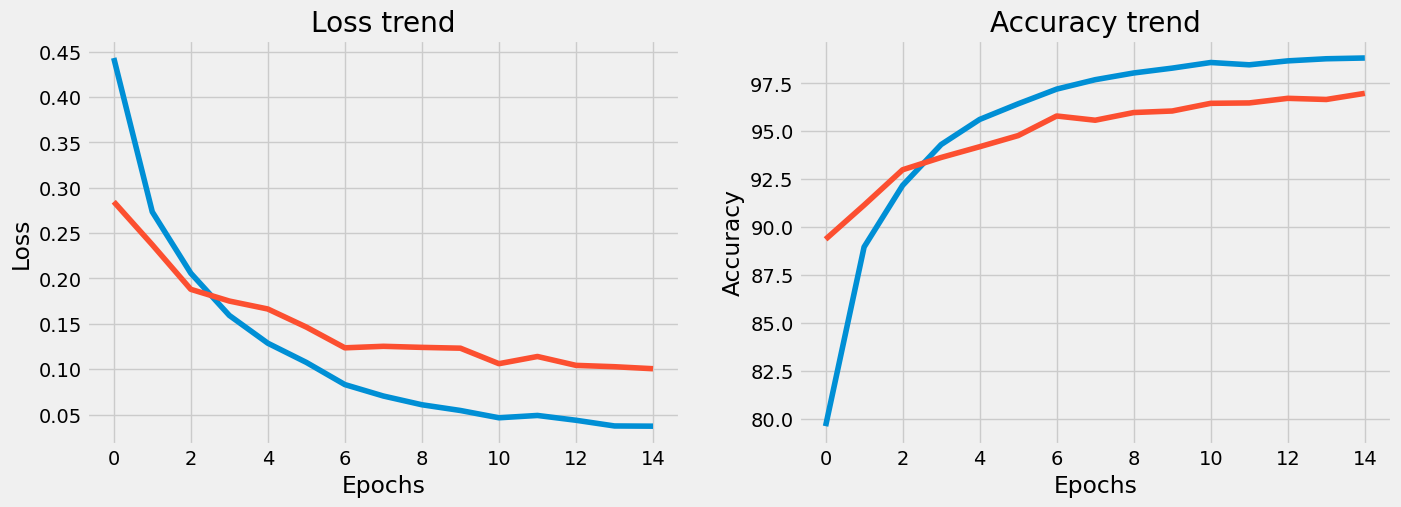

In [141]:
df=pd.read_csv('model_metrics.csv')
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(df['loss'],label='loss')
ax[0].plot(df['val_loss'],label='val loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss trend')

ax[1].plot(df['accuracy']*100,label='accuracy')
ax[1].plot(df['val_accuracy']*100,label='val accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy trend')
plt.show()

In [139]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary)}")

NameError: name 'y_test' is not defined

Tokenización basada en Frecuencias

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_preprocessed['review'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_preprocessed['review'])

Conjuntos de Entrenamiento y Testeo

In [ ]:
#padding necesario para que todas las secuencias tengan la misma longitud
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = df_preprocessed['sentiment'].values

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Embeddings de Glove

In [ ]:
# Cargar GloVe
'''glove_path = '/content/glove.6B.300d.txt'

# Cargar embeddings de GloVe
embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Crear la matriz de embeddings

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector'''

"glove_path = '/content/glove.6B.300d.txt'\n\n# Cargar embeddings de GloVe\nembedding_index = {}\nwith open(glove_path, 'r', encoding='utf-8') as f:\n    for line in f:\n        values = line.split()\n        word = values[0]\n        vector = np.asarray(values[1:], dtype='float32')\n        embedding_index[word] = vector\n\n# Crear la matriz de embeddings\n\nembedding_matrix = np.zeros((vocab_size, embedding_dim))\n\nfor word, i in word_index.items():\n    embedding_vector = embedding_index.get(word)\n    if embedding_vector is not None:\n        embedding_matrix[i] = embedding_vector"

# Creación NN Sin Embeddings Preentrenados

In [ ]:
embedding_dim = 100
vocab_size = 50000

In [ ]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True), #Embedings
    Conv1D(128, 5, activation='relu'),  #Convoluciones de 5 ngramas
    LSTM(128, return_sequences=False),  #Dependencias más largas
    #GlobalMaxPooling1D(),               #Activadores para priorizar relaciónes
    Dense(64, activation='relu'),       #Capa densa
    Dropout(0.2),                       #Evitar overfitting
    Dense(32, activation='relu'),       #Refina salida
    Dense(1, activation='sigmoid')  # Salida
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,206,081 (19.86 MB)

 Trainable params: 5,206,081 (19.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 217s 424ms/step - accuracy: 0.7566 - loss: 0.4851 - val_accuracy: 0.8624 - val_loss: 0.3257
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 266s 433ms/step - accuracy: 0.9117 - loss: 0.2430 - val_accuracy: 0.8626 - val_loss: 0.3141
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 264s 437ms/step - accuracy: 0.9507 - loss: 0.1511 - val_accuracy: 0.8601 - val_loss: 0.4189
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 287s 487ms/step - accuracy: 0.9725 - loss: 0.0898 - val_accuracy: 0.8629 - val_loss: 0.4788
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 465ms/step - accuracy: 0.9848 - loss: 0.0551 - val_accuracy: 0.8625 - val_loss: 0.5871
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 455ms/step - accuracy: 0.9862 - loss: 0.0474 - val_accuracy: 0.8543 - val_loss: 0.5423
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 230s 460ms/step - accuracy: 0.9909 - loss: 0.0336 - val_accuracy: 0.8526 - val_loss: 0.6323
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 278s 556ms/step - accuracy: 0.9937 -

In [ ]:
# Evaluar el modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to 0 or 1
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step
Accuracy on test set: 0.8596


In [ ]:
# Hacer predicciones
y_predlr = model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step


In [ ]:
# prompt: quiero convertir a y_predlr a cuanto el resutado sea mayor a 0.49 sea 1 y menor a o igual a 0

# Convertir las probabilidades a 0 o 1 según el umbral de 0.49
y_pred_binary = (y_predlr > 0.49).astype(int)

y_pred_binary

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], shape=(10000, 1))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Dividir los textos en positivos y negativos
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

# Vectorizar usando TF-IDF
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
positive_matrix = tfidf.fit_transform(positive_reviews)
negative_matrix = tfidf.fit_transform(negative_reviews)

# Extraer vocabulario y puntajes
positive_scores = pd.DataFrame(
    positive_matrix.toarray(), columns=tfidf.get_feature_names_out()
).mean().sort_values(ascending=False)

negative_scores = pd.DataFrame(
    negative_matrix.toarray(), columns=tfidf.get_feature_names_out()
).mean().sort_values(ascending=False)

# Mostrar las palabras más representativas
print("Palabras clave positivas:")
print(positive_scores.head(10))

print("\nPalabras clave negativas:")
print(negative_scores.head(10))


Palabras clave positivas:
final     0.102537
music     0.102390
live      0.045594
got       0.042636
try       0.041428
group     0.041264
stupid    0.040604
child     0.039112
rest      0.034448
matter    0.032481
dtype: float64

Palabras clave negativas:
movie        0.115430
film         0.093163
like         0.052624
bad          0.043443
character    0.040691
good         0.040622
time         0.039833
really       0.037147
make         0.036157
story        0.034525
dtype: float64


In [ ]:
# Listas de palabras clave por aspecto
aspects = {
    'acting': ['acting', 'performance', 'actor', 'actress', 'cast'],
    'plot': ['plot', 'story', 'narrative', 'screenplay'],
    'visuals': ['visual', 'effects', 'cinematography', 'scenes', 'special effects'],
    'music': ['music', 'soundtrack', 'score', 'audio']
}

# Función para contar ocurrencias de palabras clave en un texto
def count_aspect_mentions(text, aspect_keywords):
    text = text.lower()  # Convertir a minúsculas
    return sum(1 for word in aspect_keywords if word in text)

# Crear columnas para cada aspecto
for aspect, keywords in aspects.items():
    df[aspect] = df['review'].apply(lambda x: count_aspect_mentions(x, keywords))

# Promediar menciones por polaridad
aspect_summary = df.groupby('sentiment')[list(aspects.keys())].mean()

print("Promedio de menciones por polaridad:")
print(aspect_summary)


Promedio de menciones por polaridad:
            acting     plot  visuals    music
sentiment                                    
0          0.79188  0.62360  0.06932  0.15532
1          0.77900  0.58636  0.09544  0.23020


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary)}")

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

[[4372  589]
 [ 722 4317]]
Accuracy: 0.8689


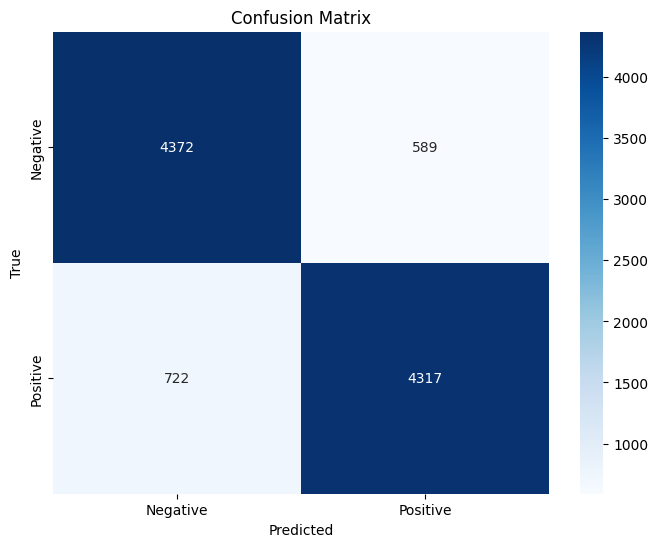

In [ ]:
# prompt: GENERA MATRIZ DE CONFUNSION DE MANERA VISUAL

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

# Assuming y_test and y_pred_binary are defined from your model's prediction
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

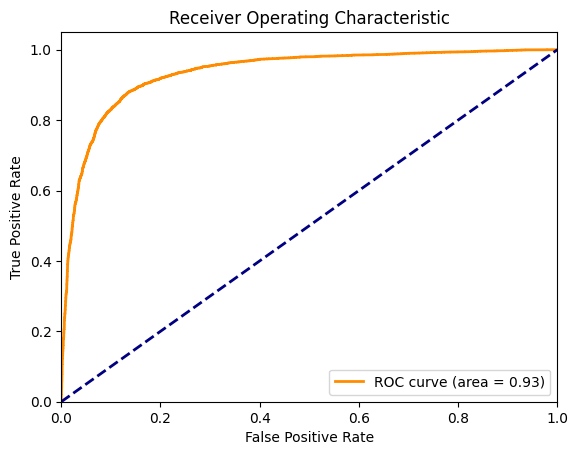

In [ ]:
# prompt: genera Curvas ROC Para evaluar la capacidad del modelo para diferenciar entre clases positivas y negativas.

from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Assuming y_test contains the true labels and y_predlr contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_predlr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

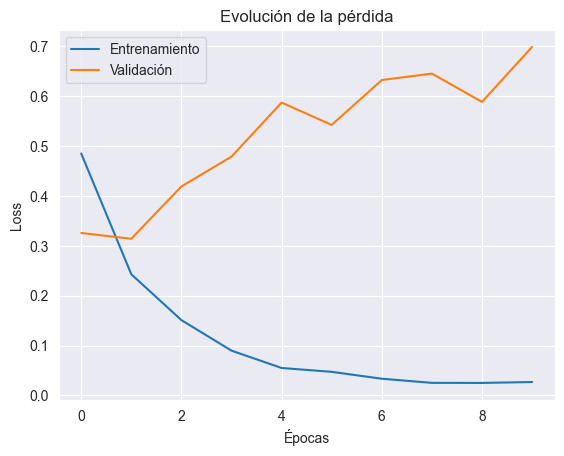

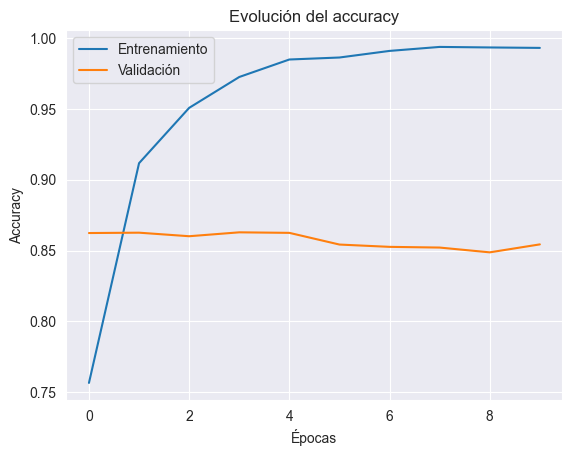

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico de accuracy (si lo tienes en metrics)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Evolución del accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
df.shape

(50000, 2)